# EDA previous to the build of the live user interface

### Library imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
from datetime import datetime, timezone

import warnings
warnings.filterwarnings('ignore')

### Working with the sample Gustavo Villatoro datasets for exploration

In [2]:
main_file = 'gustavo_villatoro_tweet.parquet'
comments_file = 'gustavo_villatoro_tweet_comments.parquet'
actor = main_file.split('.')[0].replace('_tweet', '').replace('_', ' ').title()

df_main = pd.read_parquet(main_file)
df_comments = pd.read_parquet(comments_file)

### Tweet by Gustavo Villatoro

In [3]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   url                  1 non-null      object             
 1   createdAt            1 non-null      datetime64[ns, UTC]
 2   id                   1 non-null      object             
 3   isReply              1 non-null      bool               
 4   inReplyToId          0 non-null      object             
 5   isRetweet            1 non-null      bool               
 6   isQuote              1 non-null      bool               
 7   viewCount            1 non-null      int32              
 8   retweetCount         1 non-null      int32              
 9   likeCount            1 non-null      int32              
 10  replyCount           1 non-null      int32              
 11  lang                 1 non-null      object             
 12  author__createdAt    1 non

In [4]:
df_main

,url,createdAt,id,isReply,inReplyToId,isRetweet,isQuote,viewCount,retweetCount,likeCount,replyCount,lang,author__createdAt,author__location,author__name,author__id,author__description,author__followers,author__verified,text
0,https://x.com/Vi11atoro/status/176737381352673...,2024-03-12 02:15:28+00:00,1767373813526737223,False,None,False,False,137700,434,2748,245,es,2011-04-09 23:59:59+00:00,,Gustavo Villatoro 🇸🇻,279764138,Ministro de Justicia y Seguridad Pública,66788,True,Hemos dado otro golpe contundente a la jerarqu...


### A way to display some fast facts about the original tweet without just showing the dataframe

In [5]:
def display_tweet_card(tweet):
    """ Creates a card to display fast facts from the tweet """
    
    total_views = tweet['viewCount']
    retweet_percentage = (tweet['retweetCount'] / total_views) * 100
    like_percentage = (tweet['likeCount'] / total_views) * 100
    reply_percentage = (tweet['replyCount'] / total_views) * 100

     # Calculate days ago
    current_date = datetime.now(timezone.utc).replace(tzinfo=None)
    created_date = tweet['createdAt'].astimezone(timezone.utc).replace(tzinfo=None)
    days_ago = (current_date - created_date).days

    card_html = f"""
    <div style="border:1px solid #ddd; padding: 10px; margin: 10px; border-radius: 5px; box-shadow: 2px 2px 10px rgba(0,0,0,0.1);">
        <h3 style="margin:0; color:#333;">{actor}</h3>
        <br>
        <p style="margin:5px 0; color:#555;">{tweet['text']}</p>
        <br>
        <p style="margin:5px 0; color:#555;">Language: {tweet['lang']}</p>
        <p style="margin:5px 0; color:#555;">Total Views: {tweet['viewCount']}</p>
        <p style="margin:5px 0; color:#555;">Retweets: {tweet['retweetCount']} ({retweet_percentage:.2f}%) | Likes: {tweet['likeCount']} ({like_percentage:.2f}%) | Replies: {tweet['replyCount']} ({reply_percentage:.2f}%)</p>
        <p style="margin:5px 0; color:#555;">This tweet was created {days_ago} days ago.</p>
        <p style="margin:5px 0; color:#555;">URL: {tweet['url']}</p>
    </div>
    """
    display(HTML(card_html))

In [6]:
tweet = df_main.iloc[0].to_dict()

In [7]:
display_tweet_card(tweet)

### Comments Dataframe

In [8]:
# Preprocess author_location
df_comments['author__location__category'] = df_comments['author__location'].str.lower().apply(lambda x: 'Replies from El Salvador' if 'salvador' in x else 'Other/No location')

# Preprocess lang
df_comments['lang__category'] = df_comments['lang'].apply(lambda x: 'Replies in Spanish' if x.lower() == 'es' else 'Other languages')

# Re-ordeer columns
df_comments = df_comments[['url', 'createdAt', 'id', 'isReply', 'inReplyToId', 'isRetweet', 'isQuote', 'viewCount',
                               'retweetCount', 'likeCount', 'replyCount', 'lang', 'lang__category', 'author__createdAt',
                               'author__location', 'author__location__category', 'author__followers', 'author__verified', 'text']]

In [9]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   url                         194 non-null    object             
 1   createdAt                   194 non-null    datetime64[ns, UTC]
 2   id                          194 non-null    object             
 3   isReply                     194 non-null    bool               
 4   inReplyToId                 176 non-null    object             
 5   isRetweet                   194 non-null    bool               
 6   isQuote                     194 non-null    bool               
 7   viewCount                   194 non-null    int32              
 8   retweetCount                194 non-null    int32              
 9   likeCount                   194 non-null    int32              
 10  replyCount                  194 non-null    int32             

Sadly, not all replies could be scraped, we only got 194 out of the listed 245

### Exploring some plots for the comments

In [10]:
def visualize_replies_bars_author(df_comments):

    sns.set_style('whitegrid')

    # Calculate counts and percentages
    author_location_counts = df_comments['author__location__category'].value_counts()

    # Define colors for specific categories
    colors = ['tab:purple', 'gray']
    
     # Plotting bar charts
    plt.figure(figsize=(15, 6))

    # Plot bar chart for author_location
    author_location_labels = author_location_counts.index
    author_location_colors = [colors[0] if 'Replies from El Salvador' in label else colors[1] for label in author_location_labels]
    bars = sns.barplot(x=author_location_labels, y=author_location_counts, palette=author_location_colors)
    plt.xlabel('Author Location Category')
    plt.ylabel('Number of Replies')
    plt.title('Distribution of Replies by Author Location', color='purple', fontsize=14, fontweight='bold', pad=20, **{'horizontalalignment': 'center', 'verticalalignment': 'baseline', 'bbox': {'facecolor': 'none', 'edgecolor': 'purple', 'boxstyle': 'round,pad=0.3'}, 'linespacing': 1.5})

    # Annotate with percentage inside the bars
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval}\n{yval/sum(author_location_counts)*100:.1f}%', ha='center', va='center', color='white', fontsize=10)

    # Annotate with total count
    total_author_location = sum(author_location_counts)
    plt.text(len(author_location_labels) - 0.5, -20, f'Total Replies: {total_author_location}', fontsize=12, ha='right')

    plt.tight_layout()
    plt.show()


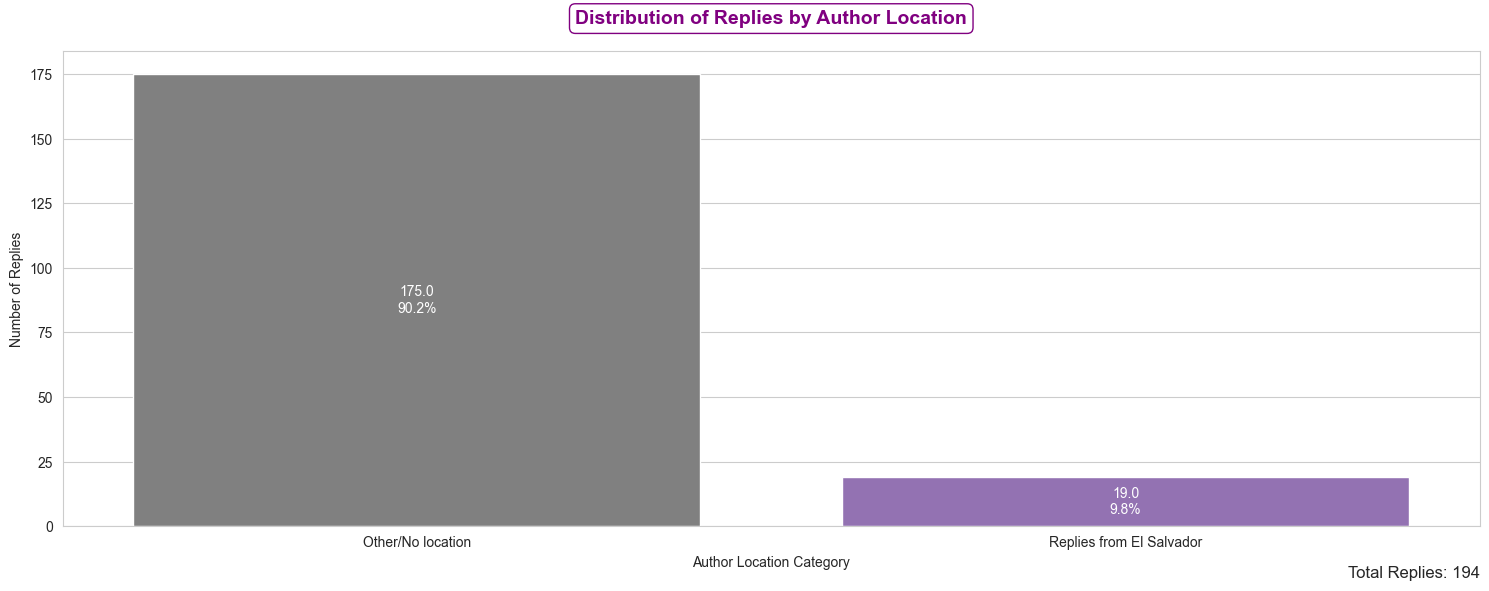

In [11]:
visualize_replies_bars_author(df_comments)

In [12]:
def visualize_replies_bars_language(df_comments):

    sns.set_style('whitegrid')

    lang_counts = df_comments['lang__category'].value_counts()

    # Define colors for specific categories
    colors = ['tab:purple', 'gray']
    
     # Plotting bar charts
    plt.figure(figsize=(15, 6))

    # Plot bar chart for lang
    lang_labels = lang_counts.index
    lang_colors = [colors[0] if 'Replies in Spanish' in label else colors[1] for label in lang_labels]
    bars = sns.barplot(x=lang_labels, y=lang_counts, palette=lang_colors)
    plt.xlabel('Language Category')
    plt.ylabel('Number of Replies')
    plt.title('Distribution of Replies by Language', color='purple', fontsize=14, fontweight='bold', pad=20, **{'horizontalalignment': 'center', 'verticalalignment': 'baseline', 'bbox': {'facecolor': 'none', 'edgecolor': 'purple', 'boxstyle': 'round,pad=0.3'}, 'linespacing': 1.5})

    # Annotate with percentage inside the bars
    for bar in bars.patches:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval/2, f'{yval}\n{yval/sum(lang_counts)*100:.1f}%', ha='center', va='center', color='white', fontsize=10)

    # Annotate with total count
    total_lang = sum(lang_counts)
    plt.text(len(lang_labels) - 0.5, -20, f'Total Replies: {total_lang}', fontsize=12, ha='right')

    plt.tight_layout()
    plt.show()

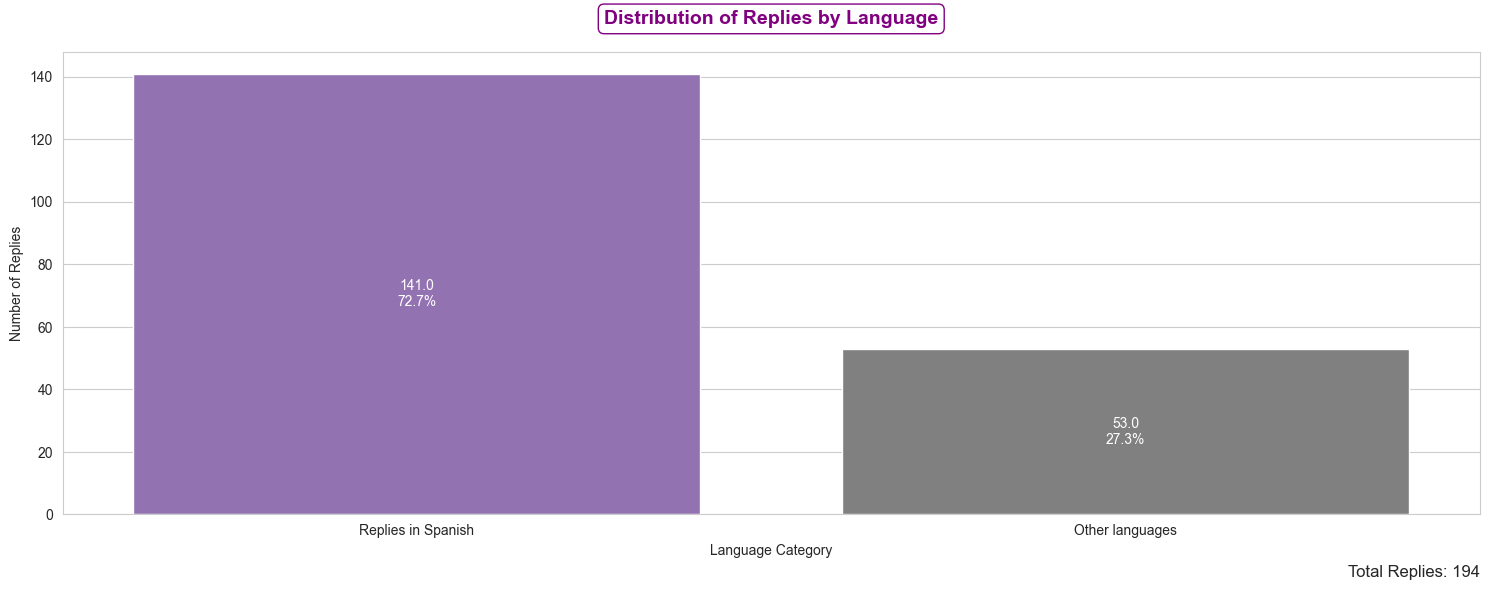

In [13]:
visualize_replies_bars_language(df_comments)

In [14]:
def visualize_replies_pie_author(df_comments):
    sns.set_style('whitegrid')

    # Calculate counts and percentages
    author_location_counts = df_comments['author__location__category'].value_counts()

    # Define colors for specific categories
    colors = ['tab:purple', 'gray']

    # Plotting pie charts
    plt.figure(figsize=(20, 6))

    # Plot pie chart for author_location
    author_location_labels = author_location_counts.index
    author_location_colors = [colors[0] if 'Replies from El Salvador' in label else colors[1] for label in author_location_labels]
    plt.pie(author_location_counts, labels=author_location_labels, colors=author_location_colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Replies by Author Location', color='purple', fontsize=14, fontweight='bold', pad=20, **{'horizontalalignment': 'center', 'verticalalignment': 'baseline', 'bbox': {'facecolor': 'none', 'edgecolor': 'purple', 'boxstyle': 'round,pad=0.3'}, 'linespacing': 1.5})

    # Annotate with total count
    total_author_location = sum(author_location_counts)
    plt.text(0, -1.5, f'Total Replies:\n{total_author_location}', fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

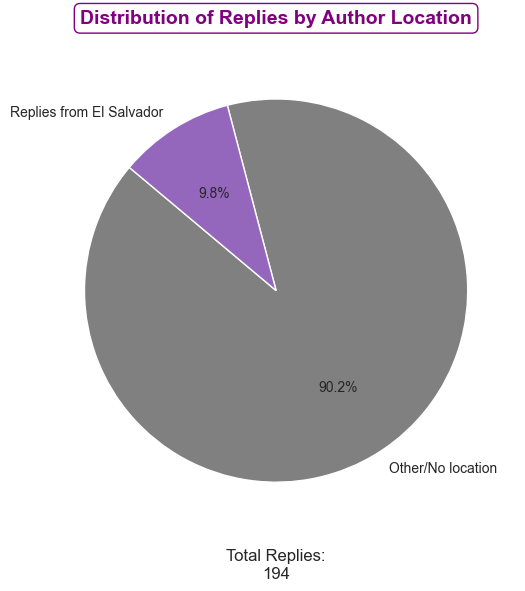

In [15]:
visualize_replies_pie_author(df_comments)

In [16]:
def visualize_replies_pie_language(df_comments):
    sns.set_style('whitegrid')

    # Calculate counts and percentages
    lang_counts = df_comments['lang__category'].value_counts()

    # Define colors for specific categories
    colors = ['tab:purple', 'gray']

    # Plotting pie charts
    plt.figure(figsize=(15, 6))

    # Plot pie chart for lang
    lang_labels = lang_counts.index
    lang_colors = [colors[0] if 'Replies in Spanish' in label else colors[1] for label in lang_labels]
    plt.pie(lang_counts, labels=lang_labels, colors=lang_colors, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Replies by Language', color='purple', fontsize=14, fontweight='bold', pad=20, **{'horizontalalignment': 'center', 'verticalalignment': 'baseline', 'bbox': {'facecolor': 'none', 'edgecolor': 'purple', 'boxstyle': 'round,pad=0.3'}, 'linespacing': 1.5})

    # Annotate with total count
    total_lang = sum(lang_counts)
    plt.text(0, -1.5, f'Total Replies:\n{total_lang}', fontsize=12, ha='center')

    plt.tight_layout()
    plt.show()

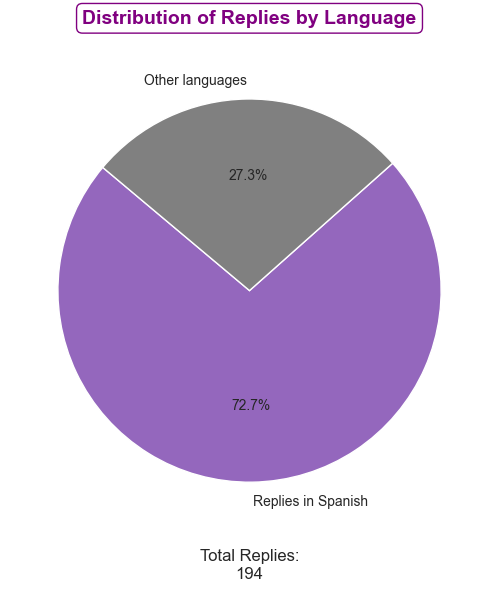

In [17]:
visualize_replies_pie_language(df_comments)